<a href="https://colab.research.google.com/github/greyhound101/multilingial/blob/master/multifit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Mounted at /content/gdrive


In [2]:
pip install transformers

     |████████████████████████████████| 778kB 3.4MB/s 
     |████████████████████████████████| 890kB 18.8MB/s 
     |████████████████████████████████| 1.1MB 25.8MB/s 
     |████████████████████████████████| 3.0MB 41.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=0844eac63cb94674e26a58f82309c8d7a6032e67277ee6bef66c6b56a371b665
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
pip install git+https://github.com/n-waves/multifit

  Cloning https://github.com/n-waves/multifit to /tmp/pip-req-build-3kpx5nb7
  Running command git clone -q https://github.com/n-waves/multifit /tmp/pip-req-build-3kpx5nb7
  Created wheel for multifit: filename=multifit-1.0-cp36-none-any.whl size=24506 sha256=f8e8da4d419879410158af5c046cb9dcd3ecb7c0e6af032347c80a7a346789fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-qt93tdus/wheels/b7/92/1e/246f31a4e84fd665b5907cb96765f696be45e814ff68a5fd4a
Successfully built multifit


In [4]:
pip install sacremoses

In [5]:
pip install sentencepiece

In [6]:
from zipfile import ZipFile 
path = F"/content/gdrive/My Drive/multilingual toxic/" 
with ZipFile(path+'toxic.zip', 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!')
import pandas as pd
def load_data():
    trn=pd.read_csv('jigsaw-toxic-comment-train.csv',usecols=['toxic','comment_text'])
    val=pd.read_csv('validation.csv',usecols=['toxic','comment_text','lang'])
    tst=pd.read_csv('test.csv',usecols=['lang','content'])  
    sub=pd.read_csv('submission (1).csv')  
    return trn,tst,val,sub
train,test,valid,sub=load_data()
test['toxic']=sub['toxic'].round()

File Name                                             Modified             Size
jigsaw-toxic-comment-train.csv                 2020-06-08 23:38:40     95538001
test.csv                                       2020-06-08 23:39:02     28783206
validation.csv                                 2020-06-08 23:38:52      3178555
submission (1).csv                             2020-06-08 23:50:22      1161879
Extracting all the files now...
Done!


In [7]:
print(train.shape,test.shape,valid.shape,sub.shape)

(223549, 2) (63812, 3) (8000, 3) (63812, 2)


In [8]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
from tensorflow.keras.layers import *
from fastai.text import *
import multifit
exp = multifit.from_pretrained("es_multifit_paper_version")
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])
fa_config =  exp.pretrain_lm.tokenizer.get_fastai_config(add_open_file_processor=True)

In [9]:
es=test.loc[test['lang']=='es']
es['id']=es.index
es=es.reset_index(drop=True)
es.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,content,lang,toxic,id
0,el skate es unos de los deportes favoritos de ...,es,0.0,7
1,Me doy la bienvenida. A este usuari le gusta c...,es,0.0,8
2,"ES NOTABLEMENTE TENDENCIOSO, NO SE HABLA DE CU...",es,0.0,9
3,"El Jardín de infantes Nº938, fundado en 1989, ...",es,0.0,22
4,Daré explicaciones y/o aclaraciones a cualquie...,es,0.0,49


In [10]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


Running on TPU  grpc://10.118.237.18:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.118.237.18:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.118.237.18:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [11]:
with strategy.scope():
    exp = multifit.from_pretrained("es_multifit_paper_version")
    fa_config =  exp.pretrain_lm.tokenizer.get_fastai_config(add_open_file_processor=True)
    data_lm = (TextList.from_df(es, **fa_config)
            .split_by_rand_pct(0.1)
            .label_for_lm()           
            .databunch(bs=32))
    learn = exp.finetune_lm.get_learner(data_lm)  
    # learn is a preconfigured fastai learner with a pretrained model loaded
data_lm.show_batch()

Training args:  {'drop_mult': 0.3, 'true_wd': False, 'wd': 1e-07, 'pretrained': False, 'clip': 0.12} config:  {'emb_sz': 400, 'n_hid': 1550, 'n_layers': 4, 'pad_token': 1, 'qrnn': True, 'bidir': False, 'output_p': 0.25, 'hidden_p': 0.1, 'input_p': 0.2, 'embed_p': 0.02, 'weight_p': 0.15, 'tie_weights': True, 'out_bias': True}


/usr/local/lib/python3.6/dist-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
Setting LM training seed seed to 0
Loading pretrained weights:  [PosixPath('/root/.fastai/models/es_multifit_paper_version/lm_best'), PosixPath('/root/.fastai/models/es_multifit_paper_version/itos')]


/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,"us ua ri ▁le ▁gu sta ▁confronta rse ▁con ▁los ▁ignora ntes ▁. ▁ ¿ ▁ xxmaj ▁va mos ▁a ▁estar ▁ tú ▁y ▁y o ▁de ▁acuerdo ▁o ▁no ▁ ? ▁( ▁discusión ▁) ▁18 ▁: ▁28 ▁27 ▁ dic ▁2014 ▁( ▁ xxup ▁ ut c ▁) ▁ xxbos ▁ xxfld ▁1 ▁ xxup ▁es ▁ xxup ▁notable mente ▁ xxup ▁ ten den ci oso ▁, ▁"
1,ria ▁a ▁ greg ar ▁a ▁mon do go ▁la ▁ tia ▁tri n ka ▁a s us to ▁y ▁los ▁de mas ▁pues ▁como ▁sabe n ▁hay ▁bastante s ▁personajes ▁si ▁mencionar ▁a ▁los ▁antiguos ▁como ▁ gon za les ▁y ▁otros ▁personajes ▁que ▁se ▁olvid aron ▁ t ambi en ▁muchos ▁bloque s ▁antiguos ▁que ▁ te nia ▁mañana ▁mal di ta ▁si ▁necesita n ▁mi ▁ayuda ▁
2,▁informa tivo ▁más ▁que ▁con tribu tivo ▁. ▁ xxmaj ▁salud os ▁y ▁dis cul pa ▁. ▁1 90 .2 . 41 ▁. ▁ xxbos ▁ xxfld ▁1 ▁como ▁es ▁posible ▁que ▁el ▁mas ▁rico ▁del ▁mundo ▁no ▁ha ga ▁algo ▁por ▁ayudar ▁al ▁pa is ▁en ▁vez ▁de ▁ser ▁el ▁hombre ▁mas ▁rico ▁del ▁mundo ▁de ve ria ▁ser ▁el ▁mas ▁cu lero ▁ ! ▁ ! ▁ !
3,"▁, ▁ ¡ ▁ xxmaj ▁ fel icidad es ▁ ! ▁a ▁mi ▁ni ▁se ▁me ▁hubiese ▁ocurrido ▁. ▁ xxmaj ▁un ▁salud o ▁. ▁ xxmaj ▁ n ix ón - ▁ ¡ ▁ þ la ti que mos ▁ ! ▁14 ▁: ▁ 03 ▁21 ▁en e ▁2009 ▁( ▁ xxup ▁ ut c ▁) ▁ xxbos ▁ xxfld ▁1 ▁ xxup ▁mira ▁ xxup ▁quien ▁ xxup"
4,"dia lo gue mos ▁... ▁ 06 ▁: ▁ 08 ▁15 ▁mar ▁2010 ▁( ▁ xxup ▁ ut c ▁) ▁ xxbos ▁ xxfld ▁1 ▁ xxmaj ▁ prop on go ▁que ▁aunque ▁sea ▁semi pro te jan ▁esta ▁página ▁, ▁porque ▁van ▁hi ba ▁de ▁estar ▁ poniendo ▁pa ya s o ▁, ▁comi en di ante ▁, ▁etc . ▁aunque ▁lo ▁par esca ▁el ▁ xxmaj ▁ s"


In [12]:
learn.fit_one_cycle(10,max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,6.617878,4.552540,0.285649,29:40
1,6.588852,4.502356,0.287957,29:25
2,6.366564,4.430468,0.295405,29:37
3,6.374557,4.362328,0.302504,29:33
4,6.105771,4.314495,0.304682,29:34
5,5.887644,4.279157,0.305226,29:27
6,5.890857,4.259118,0.305488,29:36
7,5.938403,4.242758,0.305814,29:32
8,5.802951,4.237793,0.305804,29:23
9,5.953256,4.235242,0.306163,29:43


In [13]:
self=exp.finetune_lm
CLS_BEST = 'cls_best'
LM_BEST = "lm_best"
ENC_BEST = "enc_best"
experiment_path=Path('/content')
self.experiment_path=experiment_path
tokenizer = self.base.tokenizer
print("Experiment", experiment_path)

self.experiment_path = experiment_path
tokenizer.save(self.experiment_path, learn=learn)
learn.to_fp32()
learn.save_encoder('/content/'+ENC_BEST)
learn.save(LM_BEST, with_opt=False)
# learn.destroy()
self.save_paramters()
print("Language model saved to", self.experiment_path)

Experiment /content
Copy sp model from /root/.fastai/models/es_multifit_paper_version to /content
Saving dump to /content/finetuning.json
Language model saved to /content


In [14]:
self=exp.classifier
self.base.experiment_path=Path('')
es['toxic']=es['toxic'].astype(np.long)
from pathlib import Path
with strategy.scope():
    exp.classifier.experiment_path=Path('')
    data_clas = TextClasDataBunch.from_df("", es.loc[1000:].reset_index(drop=True),es[:1000],  text_cols = 'content', label_cols = 'toxic',bs=64,vocab=data_lm.vocab)
    data_clas.vocab.itos = data_lm.vocab.itos
    l1rn = exp.classifier.get_learner(data_clas)  
# learn is a preconfigured fastai learner with a pretrained model loaded


Using Label smoothing with eps =  0.05
Setting Classifier weights seed seed to 0
Training args:  {'drop_mult': 0.5, 'wd': 0.01, 'pretrained': False, 'bptt': 70, 'loss_func': FlattenedLoss of LabelSmoothingCrossEntropy(), 'clip': 0.12, 'silent': False} config:  {'emb_sz': 400, 'n_hid': 1550, 'n_layers': 4, 'pad_token': 1, 'qrnn': True, 'bidir': False, 'output_p': 0.25, 'hidden_p': 0.1, 'input_p': 0.2, 'embed_p': 0.02, 'weight_p': 0.15}
Loading pretrained model /content/enc_best
Setting Classifier training seed seed to 0


In [15]:
data_clas.show_batch()

text,target
xxbos xxunk : / / xxunk / en / xxunk - xxunk / xxunk - xxunk - xxunk - xxunk - xxunk xxunk : / / xxunk / en / xxunk / xxunk / ? view = xxunk xxunk : / / xxunk / en / xxunk / xxunk / ? view = xxunk xxunk : / / xxunk / en / xxunk / xxunk / ? view = xxunk,0
xxbos xxup san xxup xxunk n xxrep 44 o xxup san xxup xxunk n xxrep 44 o xxup san xxup xxunk n xxrep 44 o xxup san xxup xxunk n xxrep 44 o xxup san xxup xxunk n xxrep 44 o xxup san xxup xxunk n xxrep 44 o xxup san xxup xxunk n xxrep 44 o xxup san xxup xxunk n xxrep 44 o xxup san xxup xxunk n,1
"xxbos xxup que xxup se xxup xxunk xxup xxunk xxup xxunk xxup de xxup xxunk . xxup xxunk xxup xxunk a xxup un xxup par xxup cada xxup dia , xxup me xxup xxunk xxup ver xxup xxunk xxup xxunk xxup xxunk xxup de xxup la xxup xxunk xxup xxunk , xxup xxunk xxup xxunk . xxup lo xxup que xxup me xxup xxunk xxup por xxup xxunk xxup es",1
"xxbos xxup xxunk xxup xxunk xxup xxunk a xxup xxunk , xxup xxunk xxup va a xxup xxunk xxup un 8 % xxup de xxup xxunk xxup en xxup la xxup xxunk xxup xxunk xxup xxunk xxup lo xxup que xxup xxunk xxup poniendo xxup xxunk xxup xxunk ¿ ? xxup xxunk xxup xxunk 3,5 xxup xxunk xxup de xxup xxunk xxup en xxup la xxup xxunk xxup xxunk xxup",1
"xxbos no mas xxunk xxunk xxunk xxunk una xxunk , xxunk , xxunk , xxunk xxunk oh xxunk xxup xxunk xxunk xxup xxunk xxup xxunk xxup en xxup xxunk xxunk xxup xxunk xxup ah xxup xxunk xxup xxunk xxunk xxup nos xxup mas xxup xxunk xxup en xxup las xxup xxunk xxup de xxup la xxup xxunk , xxup oh xxup de xxup xxunk y xxup xxunk xxup el xxup",0


In [16]:
l1rn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.648730,0.545382,0.760000,09:11
1,0.583833,0.578859,0.735000,08:37
2,0.544534,0.527915,0.774000,08:10
3,0.555704,0.559101,0.746000,08:09
4,0.543731,0.571725,0.732000,08:50
5,0.546090,0.537429,0.754000,08:43
6,0.547491,0.519186,0.778000,08:18
7,0.541775,0.519001,0.777000,07:47
8,0.542805,0.522196,0.776000,08:17
9,0.538746,0.530062,0.773000,07:57


In [39]:
pre1=l1rn.get_preds()

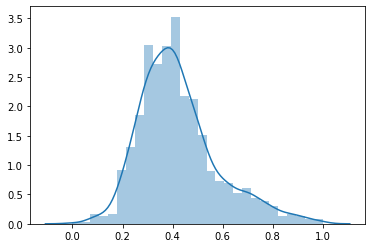

In [40]:
from sklearn.preprocessing import *
import seaborn as sns
mms=MinMaxScaler(feature_range=(0,1))
pre=mms.fit_transform(pre1[0][:,1].reshape(-1,1))
sns.distplot(pre)

In [48]:
a=es[:1000]
a

,content,lang,toxic,id
0,el skate es unos de los deportes favoritos de ...,es,0,7
1,Me doy la bienvenida. A este usuari le gusta c...,es,0,8
2,"ES NOTABLEMENTE TENDENCIOSO, NO SE HABLA DE CU...",es,0,9
3,"El Jardín de infantes Nº938, fundado en 1989, ...",es,0,22
4,Daré explicaciones y/o aclaraciones a cualquie...,es,0,49
...,...,...,...,...
995,alguien agrego palabras obsenas y falsas al ar...,es,0,7941
996,PUTOOOOO TE ODIO HIJO DE TU PUTA VIEJAAAAA CHU...,es,1,7943
997,"ese imbesil que dice que se llama pain, si es ...",es,1,7944
998,"Leer, por favor, la citada política oficial. S...",es,0,7962


In [50]:
a['toxic']=pre
a

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,content,lang,toxic,id
0,el skate es unos de los deportes favoritos de ...,es,0.505001,7
1,Me doy la bienvenida. A este usuari le gusta c...,es,0.374563,8
2,"ES NOTABLEMENTE TENDENCIOSO, NO SE HABLA DE CU...",es,0.770823,9
3,"El Jardín de infantes Nº938, fundado en 1989, ...",es,0.079049,22
4,Daré explicaciones y/o aclaraciones a cualquie...,es,0.320652,49
...,...,...,...,...
995,alguien agrego palabras obsenas y falsas al ar...,es,0.722687,7941
996,PUTOOOOO TE ODIO HIJO DE TU PUTA VIEJAAAAA CHU...,es,0.820790,7943
997,"ese imbesil que dice que se llama pain, si es ...",es,0.678685,7944
998,"Leer, por favor, la citada política oficial. S...",es,0.281257,7962


In [54]:
sub=pd.read_csv('submission(2).csv')
sub

,id,toxic
0,0,2.861023e-06
1,1,2.771616e-06
2,2,1.801245e-01
3,3,4.202128e-06
4,4,6.496906e-06
...,...,...
63807,63807,9.378535e-02
63808,63808,2.980232e-08
63809,63809,2.467930e-04
63810,63810,5.960464e-08


In [55]:
sub=sub.merge(a,on='id',how='left')
sub

,id,toxic_x,content,lang,toxic_y
0,0,2.861023e-06,NaN,NaN,NaN
1,1,2.771616e-06,NaN,NaN,NaN
2,2,1.801245e-01,NaN,NaN,NaN
3,3,4.202128e-06,NaN,NaN,NaN
4,4,6.496906e-06,NaN,NaN,NaN
...,...,...,...,...,...
63807,63807,9.378535e-02,NaN,NaN,NaN
63808,63808,2.980232e-08,NaN,NaN,NaN
63809,63809,2.467930e-04,NaN,NaN,NaN
63810,63810,5.960464e-08,NaN,NaN,NaN


In [56]:
sub.loc[:10]

,id,toxic_x,content,lang,toxic_y
0,0,2.861023e-06,NaN,NaN,NaN
1,1,2.771616e-06,NaN,NaN,NaN
2,2,1.801245e-01,NaN,NaN,NaN
3,3,4.202128e-06,NaN,NaN,NaN
4,4,6.496906e-06,NaN,NaN,NaN
5,5,1.031458e-03,NaN,NaN,NaN
6,6,6.258488e-07,NaN,NaN,NaN
7,7,4.602261e-01,el skate es unos de los deportes favoritos de ...,es,0.505001
8,8,1.011375e-01,Me doy la bienvenida. A este usuari le gusta c...,es,0.374563
9,9,5.045533e-01,"ES NOTABLEMENTE TENDENCIOSO, NO SE HABLA DE CU...",es,0.770823


In [57]:
sub=sub[['id','toxic_x','toxic_y']]
sub

,id,toxic_x,toxic_y
0,0,2.861023e-06,NaN
1,1,2.771616e-06,NaN
2,2,1.801245e-01,NaN
3,3,4.202128e-06,NaN
4,4,6.496906e-06,NaN
...,...,...,...
63807,63807,9.378535e-02,NaN
63808,63808,2.980232e-08,NaN
63809,63809,2.467930e-04,NaN
63810,63810,5.960464e-08,NaN


In [65]:
sub['toxic'] = sub.toxic_y.combine_first(sub.toxic_x)
sub.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,toxic_x,toxic_y,toxic
0,0,2.861023e-06,NaN,2.861023e-06
1,1,2.771616e-06,NaN,2.771616e-06
2,2,1.801245e-01,NaN,1.801245e-01
3,3,4.202128e-06,NaN,4.202128e-06
4,4,6.496906e-06,NaN,6.496906e-06
5,5,1.031458e-03,NaN,1.031458e-03
6,6,6.258488e-07,NaN,6.258488e-07
7,7,4.602261e-01,0.505001,5.050014e-01
8,8,1.011375e-01,0.374563,3.745630e-01
9,9,5.045533e-01,0.770823,7.708226e-01


In [66]:
sub=sub[['id','toxic']]
sub.to_csv('submission.csv',index=False)